# Guitar Chord Identifier Model

### Import Packages

In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

### Step 1: Preprocessing the Audio Files

#### Create a Dataframe of the Chord Audio Files

In [16]:
# CREATE LIST OF PATH NAMES
folder_paths = ["data/a", "data/am", "data/bm", "data/c", "data/d", "data/dm", "data/e", "data/em", "data/f", "data/g"]

# DEFINE A DATAFRAME
audio_df = pd.DataFrame(columns=['File', 'Duration', 'Sample Rate', 'Audio Samples', 'File Path', 'Chord'])

In [17]:
data = []

# LOOP THROUGH THE CHORD FOLDERS AND VISIT EACH .WAV FILE
for chord_folder in folder_paths:
    # GET THE CHORD NAME USING THE FILE PATH
    chord_name = os.path.basename(chord_folder)
    
    for chord_wav_name in os.listdir(chord_folder):
        # EXTRACT INFORMATION FROM A SINGLE .WAV FILE
        full_file_path = os.path.join(chord_folder, chord_wav_name)
        y, sr = librosa.load(full_file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        data.append({'File': chord_wav_name, 'Duration': duration, 'Sample Rate': sr, 'Audio Sample': y, 'File Path': full_file_path, 'Chord': chord_name})

# TURN THE LIST INTO A DATAFRAME
audio_df = pd.DataFrame(data)

print(audio_df)

          File  Duration  Sample Rate  \
0       a1.wav  1.184218        22050   
1      a10.wav  1.521587        22050   
2     a100.wav  1.870794        22050   
3     a101.wav  1.625397        22050   
4     a102.wav  1.776327        22050   
...        ...       ...          ...   
1995   g95.wav  2.180771        22050   
1996   g96.wav  1.873243        22050   
1997   g97.wav  2.040952        22050   
1998   g98.wav  1.957098        22050   
1999   g99.wav  1.985034        22050   

                                           Audio Sample        File Path Chord  
0     [-0.00044090126, -0.0005725771, -0.0003972128,...    data/a\a1.wav     a  
1     [0.025644582, 0.03873189, 0.034305602, 0.03391...   data/a\a10.wav     a  
2     [-0.00018296344, -0.0002981358, -0.0002974281,...  data/a\a100.wav     a  
3     [0.0004918799, 0.00016076537, -0.00018280663, ...  data/a\a101.wav     a  
4     [-0.0071322983, -0.010516543, -0.008813906, -0...  data/a\a102.wav     a  
...                  

#### Test: Display the Waveforms

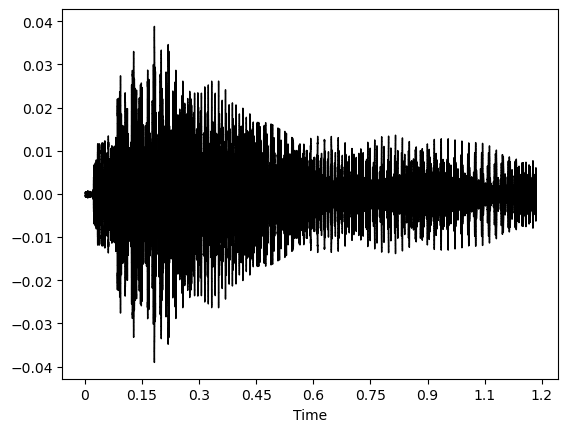

In [18]:
librosa.display.waveshow(audio_df.at[0, 'Audio Sample'], sr=audio_df.at[0, 'Sample Rate'], axis='time', color='black')

#### Function to Get Audio Features From a Single Audio .WAV

In [19]:
# PADS THE FEATURES IF THEY ARE SMALLER THAN THE EXPECTED SHAPE
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

# FUNCTION TO NORMALIZE A FEATURE
def normalize(feature):
    return (feature - np.min(feature)) / (np.max(feature) - np.min(feature))

# EXTRACTS THE NEEDED FEATURES FROM AN AUDIO FILE
def generate_features(audio_sample):
    max_size = 1000
    n_mfcc = 13
    sr = 22050

    # EXTRACT STFT, MFCCS, SPECTRAL CENTROID, CHROMA STFT, AND SPECTRAL BANDWIDTH
    stft = librosa.stft(y=audio_sample, n_fft=255, hop_length=512)
    stft = stft[:, :max_size]  # Truncate stft to max_size
    stft = padding(np.abs(stft), 128, max_size)

    mfccs = librosa.feature.mfcc(y=audio_sample, sr=sr, n_mfcc=n_mfcc)
    mfccs = mfccs[:, :max_size]  # Truncate mfccs to max_size
    mfccs = padding(mfccs, 128, max_size)

    spec_centroid = librosa.feature.spectral_centroid(y=audio_sample, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=audio_sample, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_sample, sr=sr)

    # TRUNCATE THE SIZE OF A FEATURE IF IT EXCEEDS MAX_SIZE (NEEDED FOR COMPUTATIONAL EFFICIENCY)
    spec_bw_truncated = spec_bw[:, :max_size]
    spec_centroid_truncated = spec_centroid[:, :max_size]
    chroma_stft_truncated = chroma_stft[:, :max_size]

    # CREATE THE IMAGE STACK
    image = np.array([padding(normalize(spec_bw_truncated), 1, max_size)]).reshape(1, max_size)
    image = np.append(image, padding(normalize(spec_centroid_truncated), 1, max_size), axis=0)

    # THESE THREE FEATURES ARE BEING STACKED INTO ONE DIMENSION
    for i in range(0, 9):
        image = np.append(image, padding(normalize(spec_bw_truncated), 1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid_truncated), 1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft_truncated), 12, max_size), axis=0)

    # STACK STFT AND MFCCS INTO THEIR OWN DIMENSION
    image = np.dstack((image, stft))
    image = np.dstack((image, mfccs))

    return image

#### Small Test on One Audio File

In [20]:
# SMALL TEST
index_to_use = 0
audio_sample = audio_df.at[index_to_use, 'Audio Sample']
sample_rate = audio_df.at[index_to_use, 'Sample Rate']

# GENERATE FEATURES FOR THIS SMALL TEST
feature_array = generate_features(audio_sample)

print("Feature array shape:", feature_array.shape)

Feature array shape: (128, 1000, 3)


#### Extracting Features from Every Audio File in the Data Frame (Stored in 'X')

In [21]:
features_list = []

# LOOP THROUGH THE DATAFRAME
for index, row in audio_df.iterrows():
    # GET THE AUDIO SAMPLE AND THE SAMPLE RATE FROM A SINGLE .WAV FILE
    audio_sample = row['Audio Sample']
    sample_rate = row['Sample Rate']
    
    # GENERATE FEATURES FOR THE CURRENT .WAV FILE
    features = generate_features(audio_sample)
    
    # ADD THE FEATURES TO THE FEATURES LIST
    features_list.append(features)

# TURN THE LIST INTO A NUMPY ARRAY
X = np.array(features_list)

print("Features array shape:", X.shape)

Features array shape: (2000, 128, 1000, 3)


#### Extracting the Corresponding Chord (Target) for Each Audio File in the Data Frame (Stored in 'y')

In [22]:
target_chords = []

# LOOP THROUGH THE DATAFRAME ROWS
for index, row in audio_df.iterrows():
    # GET THE CHORD NAME FROM THE DATAFRAME
    chord_label = row['Chord']
    
    # ADD THE CHORD LABEL TO THE LIST
    target_chords.append(chord_label)

# TURN THE LIST INTO A NUMPY ARRAY
y_cat = np.array(target_chords)

print("Target array shape:", y_cat.shape)

Target array shape: (2000,)


#### Convert Categorical Labels to Numerical Labels

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_cat)

# LABELS 0-9 ARE ASSOCIATED WITH THE FOLLOWING CATEGORICAL LABELS:
print(label_encoder.classes_)

['a' 'am' 'bm' 'c' 'd' 'dm' 'e' 'em' 'f' 'g']


#### Extract training, testing, and validation sets

In [24]:
seed = 42

# DO A 70-15-15 SPLIT

# SPLIT TO GET THE TRAINING AND TESTING SET
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

# SPLIT AGAIN TO GET THE VALIDATION SET
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

print(X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val))

(1400, 128, 1000, 3) (300, 128, 1000, 3) (300, 128, 1000, 3) 1400 300 300


### Step 2: Training the CNN Model

#### Create and Compile Model

In [135]:
input_shape = feature_array.shape

CNNmodel = models.Sequential()

# INPUT LAYER
CNNmodel.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))

# HIDDEN LAYERS (CONVOLUTIONAL LAYERS)
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))

CNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))

CNNmodel.add(layers.Flatten())

# DENSE LAYERS
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.1))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))

# OUTPUT LAYER
CNNmodel.add(layers.Dense(24, activation='softmax'))

# COMPILE THE CNN
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

# FIT THE CNN MODEL
history = CNNmodel.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

C:\Users\KevinC\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.0922 - loss: 10.2995 - val_accuracy: 0.1200 - val_loss: 2.5530
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.1721 - loss: 2.5527 - val_accuracy: 0.3133 - val_loss: 2.0334
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.3574 - loss: 1.9011 - val_accuracy: 0.6400 - val_loss: 1.0989
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.6086 - loss: 1.2060 - val_accuracy: 0.8867 - val_loss: 0.3608
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.7793 - loss: 0.6014 - val_accuracy: 0.9167 - val_loss: 0.2299
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.8552 - loss: 0.4888 - val_accuracy: 0.9333 - val_loss: 0.2183
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.8717 - loss: 0.3538 - val_accuracy: 0.9700 - val_loss: 0.1054
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.9025 - loss: 0.2822 - val_accuracy: 0.9533 - 

In [136]:
# SAVE THE MODEL
CNNmodel.save("cnn_attempt_98_acc.h5")

#### Determine the Model's Testing Accuracy

In [25]:
from tensorflow.keras.models import load_model

# LOAD THE MODEL
model = load_model('cnn_attempt_98_acc.h5')

# GET ACCURACY ON TESTING DATA
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 833ms/step - accuracy: 0.9385 - loss: 0.1767
Test loss: 0.15192735195159912
Test accuracy: 0.9466666579246521


### Step 3: Evaluating the Model

#### Individual Audio

In [29]:
model = load_model('cnn_attempt_98_acc.h5')

audio_file = 'data/c_piano.wav'

audio_sample, sr = librosa.load(audio_file)
features = generate_features(audio_sample)
features = np.expand_dims(features, axis=0)

predictions = model.predict(features)
predicted_class = np.argmax(predictions)
predicted_categorical_label = label_encoder.inverse_transform([predicted_class])[0]

print(f"For audio file {audio_file}, predicted chord: {predicted_categorical_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
For audio file c_piano.wav, predicted chord: c


#### Chord Set Played by Kevin

In [30]:
model = load_model('cnn_attempt_98_acc.h5')

for i in range(1, 25):
    audio_file = f'data/kevin_guitar_test/c/{i}.wav'

    audio_sample, sr = librosa.load(audio_file)
    features = generate_features(audio_sample)
    features = np.expand_dims(features, axis=0)

    predictions = model.predict(features)
    predicted_class = np.argmax(predictions)
    predicted_categorical_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"For audio file {audio_file}, predicted chord: {predicted_categorical_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
For audio file kevin_guitar_test/c/1.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
For audio file kevin_guitar_test/c/2.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
For audio file kevin_guitar_test/c/3.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
For audio file kevin_guitar_test/c/4.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
For audio file kevin_guitar_test/c/5.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
For audio file kevin_guitar_test/c/6.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
For audio file kevin_guitar_test/c/7.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
For audio file kevin_guitar_test/c/8.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
For audio file kevin_guitar_test/c/9.wav, predicted chord: c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
For audio file kevin_guitar_test/c/10.wav, predicted chord: c
1/